## Transfer learning in image classification

In [2]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import Sequential


## Make prediction based on ready made model with out any training

In [3]:

IMAGE_SHAPE = (224, 224)

classifier = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224,224,3))
])

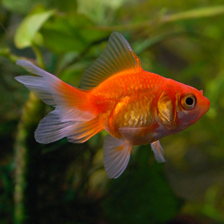

In [4]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [5]:

gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [6]:
gold_fish[np.newaxis,  ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [7]:
result = classifier.predict(gold_fish[np.newaxis,  ...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

In [8]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [9]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

## Load flowers dataset

In [10]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)

228813984/228813984 [==============================] - 22s 0us/step


In [11]:
import pathlib
data_dir  = pathlib.Path('./datasets/flower_photos/flower_photos')
data_dir


WindowsPath('datasets/flower_photos/flower_photos')

In [12]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [13]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))

}

In [14]:
flowers_label_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

In [15]:
x,y = [],[]
for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224,224))
        x.append(resized_img)
        y.append(flowers_label_dict[flower_name])

In [16]:
x = np.array(x)
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0)

In [18]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [29]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

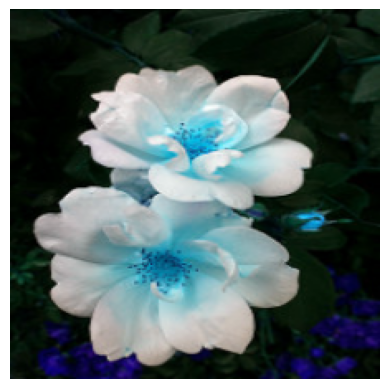

In [19]:
x0_resized = cv2.resize(x[0], IMAGE_SHAPE)
x1_resized = cv2.resize(x[1], IMAGE_SHAPE)
x2_resized = cv2.resize(x[2], IMAGE_SHAPE)
plt.axis('off')
plt.imshow(x[0])

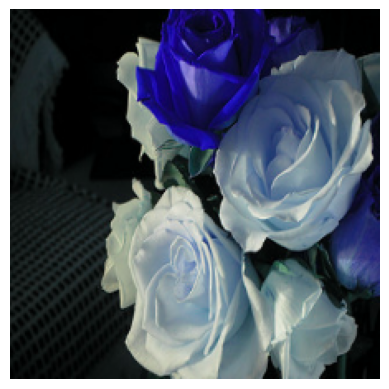

In [20]:
plt.axis('off')
plt.imshow(x[1])

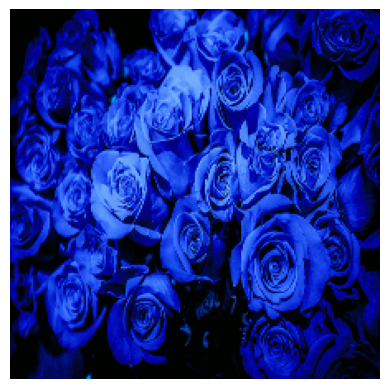

In [21]:
plt.axis('off')
plt.imshow(x[2])

In [22]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 2s 2s/step


array([795, 880, 795], dtype=int64)

In [23]:
image_labels[795]

'shower curtain'

In [24]:
image_labels[880]

'umbrella'

## Now take pre-trained model and retrain it using flowers images

In [25]:

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape= (224,224,3), trainable=False
)


In [26]:
num_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_flowers, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 [==============================] - 80s 847ms/step - loss: 0.7105 - accuracy: 0.7333
Epoch 2/5
86/86 [==============================] - 97s 1s/step - loss: 0.4112 - accuracy: 0.8586
Epoch 3/5
86/86 [==============================] - 103s 1s/step - loss: 0.3208 - accuracy: 0.8906
Epoch 4/5
86/86 [==============================] - 89s 1s/step - loss: 0.2702 - accuracy: 0.9106
Epoch 5/5
86/86 [==============================] - 89s 1s/step - loss: 0.2253 - accuracy: 0.9317


In [31]:
model.evaluate(x_test_scaled, y_test)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 36s 1s/step - loss: 0.3899 - accuracy: 0.8529


[0.3899226188659668, 0.8529411554336548]